# Анализ данных Московского метрополитена

## Описание проекта
Проект посвящён анализу пассажиропотока, географии и операционной эффективности Московского метрополитена и МЦД.  
Цель: выявить ключевые тренды, оценить эффективность линий и станций.  
Результаты предназначены для портфолио аналитика данных.

## Источники данных
Данные получены с портала [data.mos.ru](https://data.mos.ru).  
Лицензия: [CC BY 4.0](https://creativecommons.org/licenses/by/4.0/deed.ru).  
В соответствии с [нормативной базой](https://data.gov.ru/normative_base).

### Датасеты:
- `data-624`: Станции метро и вестибюли
- `data-62743`: Пассажиропоток по станциям
- `data-62888`: Станции МЦД
- `data-62523`: Годовой пассажиропоток
- `data-62745`: Точность расписания
- `data-658`: Тарифы
- `data-62207`: Входы/выходы МЦД
- `data-62741`: Характеристики линий метро

## Инициализация и загрузка данных

### Используемые библиотеки:
- `pandas`, `numpy` — обработка и анализ данных
- `matplotlib`, `seaborn` — статическая визуализация
- `folium` — интерактивные карты
- `%matplotlib inline` — отображение графиков в ноутбуке

### Настройки:
- Стиль графиков: `seaborn-v0_8`, палитра `husl`
- Отображение таблиц: все столбцы, до 50 строк

### Загрузка и очистка данных:
- Источник: портал [data.mos.ru](https://data.mos.ru)
- Формат: CSV, разделитель `;`, кодировка UTF-8
- Пропущена первая строка (описание)
- Выполнена очистка:
  - `passenger_flow`: `Входы/Выходы` → `float`, пропуски → 0, добавлен `Общий пассажиропоток`
  - `stations`: координаты → `float`, удалены строки с `NaN`
  - `yearly_traffic`: `Пассажирский поток` → `float`, удалена колонка `Unnamed: 5`

**Загружено 8 датасетов.**

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import MarkerCluster
from collections import Counter
import re

%matplotlib inline
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

In [38]:
from IPython.display import display

def styled_table(df, title="", wrap_columns=None, max_width='300px'):
    """
    Универсальная функция для красивого отображения таблиц со Styler
    
    Parameters:
    -----------
    df : DataFrame
        Таблица для отображения
    title : str, optional
        Заголовок таблицы. Если не указан, заголовок не выводится
    wrap_columns : list, optional
        Список колонок для переноса текста. Если None, перенос применяется 
        ко всем текстовым колонкам (object и string типы)
    max_width : str, optional
        Максимальная ширина ячеек в CSS-формате (по умолчанию '300px')
    
    Examples:
    ---------
    >>> styled_table(df, "Моя таблица")
    >>> styled_table(df, "Отчет", wrap_columns=['Описание', 'Комментарий'])
    >>> styled_table(df, max_width='400px')
    """
    if title:
        print(f"\n{title}")
    
    styler = df.style
    
    # Определяем колонки для переноса (все текстовые если не указано)
    if wrap_columns is None:
        wrap_columns = df.select_dtypes(include=['object', 'string']).columns.tolist()
    
    # Применяем перенос текста
    properties = {
        'white-space': 'pre-wrap',    # Сохраняет пробелы и переносы
        'word-wrap': 'break-word',    # Разрешает перенос слов
        'max-width': max_width,       # Ограничивает ширину ячеек
        'text-align': 'left'          # Выравнивание по левому краю
    }
    
    for col in wrap_columns:
        if col in df.columns:
            styler = styler.set_properties(subset=[col], **properties)
    
    display(styler)

def extract_coords(geodata):
    if pd.isna(geodata):
        return None
    match = re.search(r'coordinates=\[([-\d.]+),\s*([-\d.]+)\]', geodata)
    return [float(match.group(2)), float(match.group(1))] if match else None

In [39]:
def load_metro_datasets_clean():
    """
    Загружает и очищает датасеты Московского метрополитена.
    
    Returns:
        dict: Словарь с очищенными DataFrame.
    """
    datasets = {}
    csv_kwargs = {
        'encoding': 'utf-8',
        'sep': ';',
        'quotechar': '"',
        'skiprows': 1,
        'on_bad_lines': 'skip'
    }
    
    files = {
        'stations': '../data/data-624.csv',
        'passenger_flow': '../data/data-62743.csv',
        'mcd_stations': '../data/data-62888.csv',
        'yearly_traffic': '../data/data-62523.csv',
        'schedule_precision': '../data/sub/data-62745.csv',
        'tariffs': '../data/sub/data-658.csv',
        'mcd_entrances': '../data/sub/data-62207.csv',
        'line_characteristics': '../data/sub/data-62741.csv'
    }
    
    for name, path in files.items():
        df = pd.read_csv(path, **csv_kwargs)
        
        if name == 'passenger_flow':
            df['Входы пассажиров'] = pd.to_numeric(df['Входы пассажиров'], errors='coerce')
            df['Выходы пассажиров'] = pd.to_numeric(df['Выходы пассажиров'], errors='coerce')
            df.fillna({'Входы пассажиров': 0, 'Выходы пассажиров': 0}, inplace=True)
            df['Общий пассажиропоток'] = df['Входы пассажиров'] + df['Выходы пассажиров']
            
        elif name == 'stations':
            df['Долгота в WGS-84'] = pd.to_numeric(df['Долгота в WGS-84'], errors='coerce')
            df['Широта в WGS-84'] = pd.to_numeric(df['Широта в WGS-84'], errors='coerce')
            df.dropna(subset=['Долгота в WGS-84', 'Широта в WGS-84'], inplace=True)
            
        elif name == 'yearly_traffic':
            df['Пассажирский поток'] = pd.to_numeric(df['Пассажирский поток'], errors='coerce')
            if 'Unnamed: 5' in df.columns:
                df.drop(columns=['Unnamed: 5'], inplace=True)
                
        datasets[name] = df
    
    return datasets

# --- Загрузка ---
metro_data_clean = load_metro_datasets_clean()
display(f"Загружено {len(metro_data_clean)} датасетов")

'Загружено 8 датасетов'

## Вкладка 1: Анализ пассажиропотока

### ТОП-10 станций по общему пассажиропотоку
Анализ станций выполнен с учётом привязки станции к линиям метрополитена.  
Пассажиропоток: сумма входов и выходов за весь период.  
Визуализация: горизонтальный барчарт + соотношение входов/выходов.

ТОП-10 станций по пассажиропотоку:


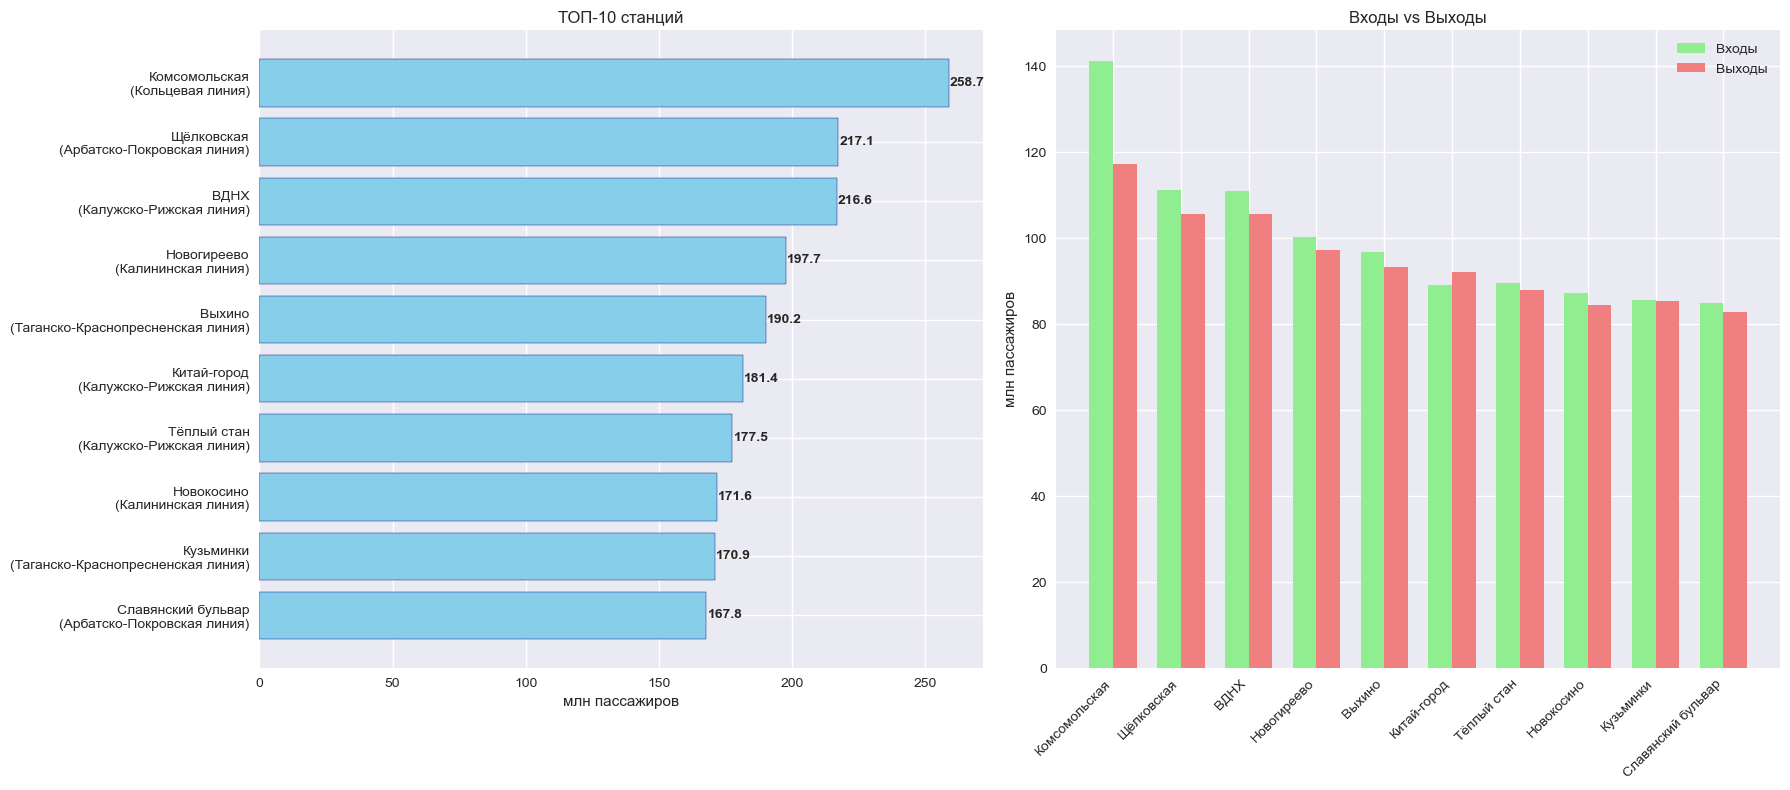


Статистика:
• Всего станций-линий: 311
• Суммарный поток: 19,912,220,822
• Средний: 64,026,434
• Лидер: Славянский бульвар (Арбатско-Покровская линия) — 167,751,176


In [40]:
# --- Анализ и визуализация пассажиропотока ---
def analyze_passenger_flow():
    df = metro_data_clean['passenger_flow']
    
    # Группировка
    traffic = df.groupby(['Станция метрополитена', 'Линия']).agg({
        'Входы пассажиров': 'sum',
        'Выходы пассажиров': 'sum',
        'Общий пассажиропоток': 'sum'
    }).reset_index()
    
    # ТОП-10
    top = traffic.nlargest(10, 'Общий пассажиропоток')
    
    # Таблица
    print("ТОП-10 станций по пассажиропотоку:")
    display(top.style.format({
        'Входы пассажиров': '{:,.0f}',
        'Выходы пассажиров': '{:,.0f}',
        'Общий пассажиропоток': '{:,.0f}'
    }))
    
    # --- Графики ---
    top_sorted = top.sort_values('Общий пассажиропоток')
    labels = [f"{r['Станция метрополитена']}\n({r['Линия']})" for _, r in top_sorted.iterrows()]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
    
    # ТОП-10
    ax1.barh(labels, top_sorted['Общий пассажиропоток'] / 1e6, color='skyblue', edgecolor='navy')
    ax1.set_xlabel('млн пассажиров')
    ax1.set_title('ТОП-10 станций')
    for i, v in enumerate(top_sorted['Общий пассажиропоток'] / 1e6):
        ax1.text(v + 0.5, i, f'{v:.1f}', va='center', fontweight='bold')
    
    # Входы/Выходы
    x = range(len(top))
    w = 0.35
    ax2.bar([i - w/2 for i in x], top['Входы пассажиров'] / 1e6, w, label='Входы', color='lightgreen')
    ax2.bar([i + w/2 for i in x], top['Выходы пассажиров'] / 1e6, w, label='Выходы', color='lightcoral')
    ax2.set_xticks(x)
    ax2.set_xticklabels([r['Станция метрополитена'] for _, r in top.iterrows()], rotation=45, ha='right')
    ax2.set_ylabel('млн пассажиров')
    ax2.set_title('Входы vs Выходы')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    # --- Статистика ---
    print(f"\nСтатистика:")
    print(f"• Всего станций-линий: {len(traffic)}")
    print(f"• Суммарный поток: {traffic['Общий пассажиропоток'].sum():,.0f}")
    print(f"• Средний: {traffic['Общий пассажиропоток'].mean():,.0f}")
    print(f"• Лидер: {top.iloc[-1]['Станция метрополитена']} ({top.iloc[-1]['Линия']}) — {top.iloc[-1]['Общий пассажиропоток']:,.0f}")

# --- Визуализация ---
analyze_passenger_flow()

## Вкладка 2: Географический анализ

### Интерактивная карта станций метро Москвы
**Без атрибуции и флагов** (чисто для портфолио)
- Только станции **на территории Москвы**
- Цвет маркера — **по линии**
- Popup: станция, линия, район, округ
- Tooltip: название и линия

In [41]:
def create_metro_map(stations_df):
    """
    Создаёт чистую интерактивную карту метро для портфолио.
    """
    # === Фильтрация и координаты ===
    moscow_stations = stations_df[stations_df['На территории Москвы'] == 'да'].copy()
    moscow_stations['Долгота в WGS-84'] = pd.to_numeric(moscow_stations['Долгота в WGS-84'], errors='coerce')
    moscow_stations['Широта в WGS-84'] = pd.to_numeric(moscow_stations['Широта в WGS-84'], errors='coerce')
    moscow_stations = moscow_stations.dropna(subset=['Долгота в WGS-84', 'Широта в WGS-84'])
    
    # === Статистика ===
    print("Статистика:")
    print(f"• Станций в Москве: {len(moscow_stations)}")
    print(f"• Уникальных: {moscow_stations['Станция метрополитена'].nunique()}")
    print(f"• Линий: {moscow_stations['Линия'].nunique()}")

    # === Карта ===
    metro_map = folium.Map(
        location=[55.7558, 37.6173],
        zoom_start=11,
        tiles='OpenStreetMap',
        attr='', 
        scrollWheelZoom='center' 
    )

    # === Убираем Leaflet и OpenStreetMap подпись ===
    metro_map.get_root().html.add_child(folium.Element("""
    <style>
        .leaflet-control-attribution {
            display: none !important;
        }
    </style>
    """))

    # === Цвета линий ===
    line_colors = {
        'Сокольническая линия': 'red',
        'Замоскворецкая линия': 'green',
        'Арбатско-Покровская линия': 'blue',
        'Филёвская линия': 'lightblue',
        'Кольцевая линия': 'purple',
        'Калужско-Рижская линия': 'orange',
        'Таганско-Краснопресненская линия': 'darkpurple',
        'Калининская линия': 'lightred',
        'Серпуховско-Тимирязевская линия': 'gray',
        'Люблинско-Дмитровская линия': 'lightgreen',
        'Каховская линия': 'cadetblue',
        'Бутовская линия': 'darkgreen',
        'Бутовская линия Лёгкого метро': 'lightgray',
        'Некрасовская линия': 'pink',
        'Солнцевская линия': 'orange',
        'Большая кольцевая линия': 'lightred',
        'Московское центральное кольцо': 'darkred',
        'Троицкая линия': 'darkgreen',
        'МЦД-1': 'lightblue',
        'МЦД-2': 'darkpurple',
        'МЦД-3': 'orange',
        'МЦД-4': 'darkgreen'
    }

    # === Маркеры ===
    for _, row in moscow_stations.iterrows():
        popup = f"""
        <b>{row['Станция метрополитена']}</b><br>
        Линия: {row['Линия']}<br>
        Район: {row['Район']}<br>
        Округ: {row['Административный округ']}
        """
        color = line_colors.get(row['Линия'], 'black')
        
        folium.Marker(
            [row['Широта в WGS-84'], row['Долгота в WGS-84']],
            popup=folium.Popup(popup, max_width=300),
            tooltip=f"<b>{row['Станция метрополитена']}</b><br>Линия: {row['Линия']}",
            icon=folium.Icon(color=color, icon='subway', prefix='fa')
        ).add_to(metro_map)

    return metro_map

# === Создание ===
metro_map = create_metro_map(metro_data_clean['stations'])
metro_map.get_root().width = "1200px"
metro_map.get_root().height = "700px"
metro_map

Статистика:
• Станций в Москве: 1146
• Уникальных: 256
• Линий: 16


### Особенности:
- CSS: скрыта атрибуция Leaflet  
- `tiles='OpenStreetMap'` — русский язык  

## Вкладка 3: Пересадки МЦД ↔ Метро

Анализ интеграции МЦД с метрополитеном:
- Извлечение пересадок из `geoData`
- Топ-станции и линии
- Визуализация: пай-чарт, барчарты, карта

In [42]:
# Фильтрация и извлечение
mask = metro_data_clean['mcd_stations']['Пересадка на станцию метро и МЦК'].notna()
stations_with_transfers = metro_data_clean['mcd_stations'][mask]

def extract_metro_transfers(text, mcd_name):
    transfers = []
    if pd.isna(text):
        return transfers
    for block in text.split('\n\n'):
        if not block.strip():
            continue
        lines = block.split('\n')
        station = next((l.split('MetroStation:')[1].strip() for l in lines if 'MetroStation:' in l), None)
        line = next((l.split('MetroLine:')[1].strip() for l in lines if 'MetroLine:' in l), None)
        if station and line:
            transfers.append({'station': station, 'line': line, 'mcd_station': mcd_name})
    return transfers

all_transfers = [
    t for _, row in stations_with_transfers.iterrows()
    for t in extract_metro_transfers(row['Пересадка на станцию метро и МЦК'], row['Наименование станции МЦД'])
]

print(f"Всего пересадок: {len(all_transfers)}")
if all_transfers:
    station_counts = Counter(t['station'] for t in all_transfers)
    line_counts = Counter(t['line'] for t in all_transfers)
    mcd_counts = Counter(t['mcd_station'] for t in all_transfers)
    
    print(f"Уникальных станций метро: {len(station_counts)}")
    print(f"Уникальных линий: {len(line_counts)}")
    print(f"Уникальных станций МЦД: {len(mcd_counts)}")

Всего пересадок: 89
Уникальных станций метро: 52
Уникальных линий: 14
Уникальных станций МЦД: 47


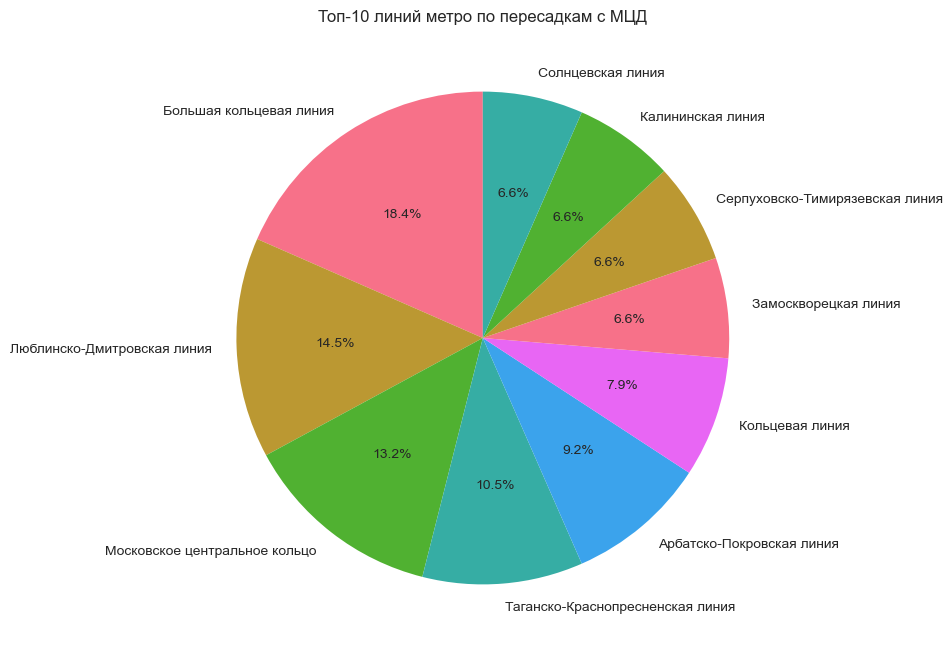

In [43]:
# Пай-чарт
if all_transfers and line_counts:
    top_lines = line_counts.most_common(10)
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.pie([c for _, c in top_lines], labels=[l for l, _ in top_lines], autopct='%1.1f%%', startangle=90)
    ax.set_title('Топ-10 линий метро по пересадкам с МЦД')
    plt.show()

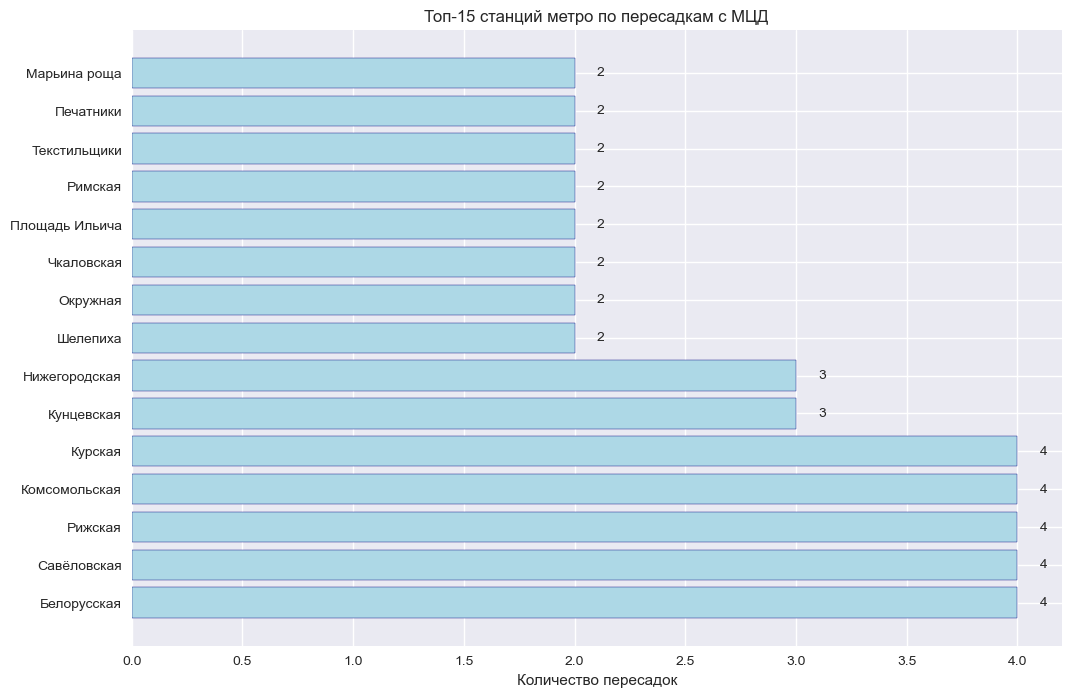

In [44]:
# Барчарт метро
if all_transfers and station_counts:
    top_stations = station_counts.most_common(15)
    names, values = zip(*top_stations)
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.barh(names, values, color='lightblue', edgecolor='navy')
    ax.set_xlabel('Количество пересадок')
    ax.set_title('Топ-15 станций метро по пересадкам с МЦД')
    for i, v in enumerate(values):
        ax.text(v + 0.1, i, str(v), va='center')
    plt.show()

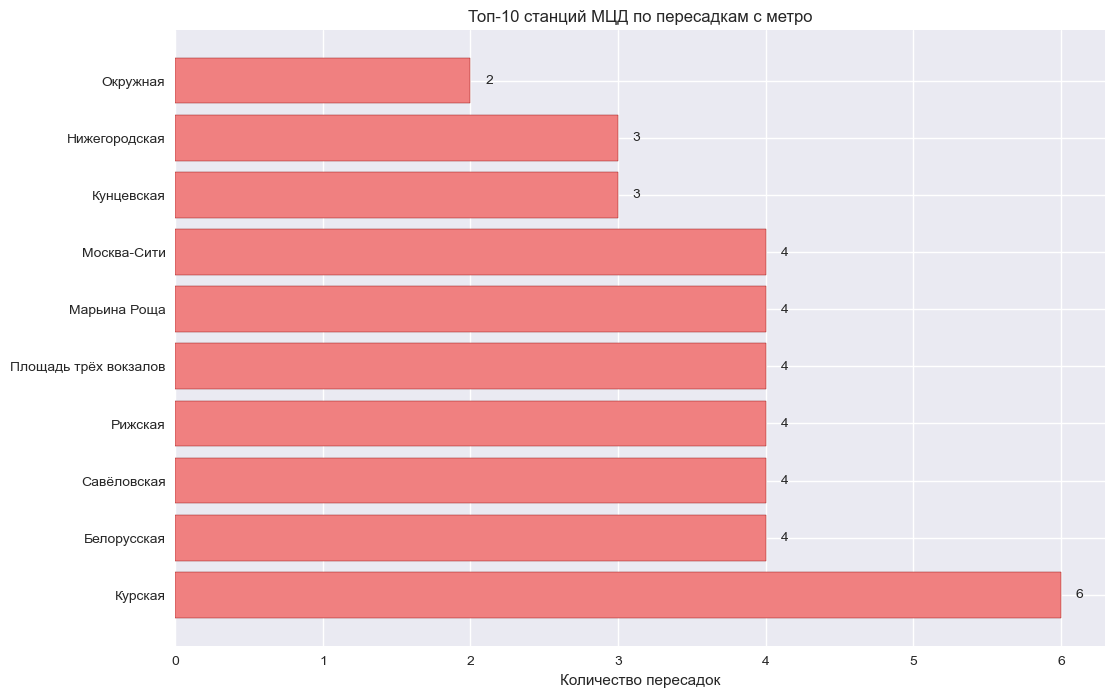

In [45]:
# Барчарт МЦД
if all_transfers and mcd_counts:
    top_mcd = mcd_counts.most_common(10)
    names, values = zip(*top_mcd)
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.barh(names, values, color='lightcoral', edgecolor='darkred')
    ax.set_xlabel('Количество пересадок')
    ax.set_title('Топ-10 станций МЦД по пересадкам с метро')
    for i, v in enumerate(values):
        ax.text(v + 0.1, i, str(v), va='center')
    plt.show()

In [46]:
# Карта
connections = []
for t in all_transfers:
    mcd_row = metro_data_clean['mcd_stations'][
        metro_data_clean['mcd_stations']['Наименование станции МЦД'] == t['mcd_station']
    ]
    metro_row = metro_data_clean['stations'][
        (metro_data_clean['stations']['Станция метрополитена'] == t['station']) &
        (metro_data_clean['stations']['Линия'] == t['line'])
    ]
    if not mcd_row.empty and not metro_row.empty:
        mcd_coords = extract_coords(mcd_row.iloc[0]['geoData'])
        metro_coords = [metro_row.iloc[0]['Широта в WGS-84'], metro_row.iloc[0]['Долгота в WGS-84']]
        if mcd_coords:
            connections.append({
                'mcd_coords': mcd_coords,
                'metro_coords': metro_coords,
                'mcd': t['mcd_station'],
                'metro': t['station'],
                'line': t['line']
            })

transfer_map = folium.Map(
    location=[55.7558, 37.6173],
    zoom_start=10,
    tiles='OpenStreetMap',
    attr='',
)

transfer_map.get_root().html.add_child(folium.Element("""
<style>
    .leaflet-control-attribution { display: none !important; }
</style>
"""))

for c in connections:
    folium.Marker(
        c['mcd_coords'],
        popup=f"<b>МЦД:</b> {c['mcd']}",
        icon=folium.Icon(color='blue', icon='train', prefix='fa')
    ).add_to(transfer_map)
    
    folium.Marker(
        c['metro_coords'],
        popup=f"<b>Метро:</b> {c['metro']}<br><b>Линия:</b> {c['line']}",
        icon=folium.Icon(color='red', icon='subway', prefix='fa')
    ).add_to(transfer_map)
    
    folium.PolyLine(
        [c['mcd_coords'], c['metro_coords']],
        color='green',
        weight=3,
        opacity=0.6
    ).add_to(transfer_map)

transfer_map.get_root().width = "1200px"
transfer_map.get_root().height = "700px"
transfer_map

In [47]:
print("\nВыводы:")
print(f"• Всего пересадок: {len(all_transfers)}")
print(f"• Лидеры по пересадкам: {', '.join([s for s, _ in station_counts.most_common(3)])}")
print(f"• Самые загруженные линии: {', '.join([l for l, _ in line_counts.most_common(2)])}")
print("• Карта показывает плотную интеграцию МЦД с метро")


Выводы:
• Всего пересадок: 89
• Лидеры по пересадкам: Белорусская, Савёловская, Рижская
• Самые загруженные линии: Большая кольцевая линия, Люблинско-Дмитровская линия
• Карта показывает плотную интеграцию МЦД с метро


## Вкладка 4: Пассажиропоток

Анализ годового и квартального пассажиропотока:
- Динамика по годам
- Влияние пандемии
- Сезонные паттерны
- Визуализация: линейные графики, барчарты

In [48]:
# Годовой пассажиропоток
yearly_traffic = metro_data_clean['yearly_traffic']
metro_traffic = yearly_traffic[
    yearly_traffic['Вид общественного транспорта'] == 'Московский метрополитен'
].copy()
metro_traffic['Пассажирский поток (млн)'] = metro_traffic['Пассажирский поток'] / 1e6

yearly_clean = yearly_traffic.drop(columns=['Unnamed: 5'], errors='ignore')
yearly_summary = yearly_clean.groupby('Год')['Пассажирский поток'].sum().reset_index()
yearly_summary['Пассажирский поток (млрд)'] = yearly_summary['Пассажирский поток'] / 1e9

display(yearly_summary.sort_values('Год'))

Год  Пассажирский поток  Пассажирский поток (млрд)
0  2019          4192986854                   4.192987
1  2020          2657034372                   2.657034
2  2021          3100722916                   3.100723
3  2022          3334487252                   3.334487
4  2023          3521245730                   3.521246
5  2024          3714878380                   3.714878

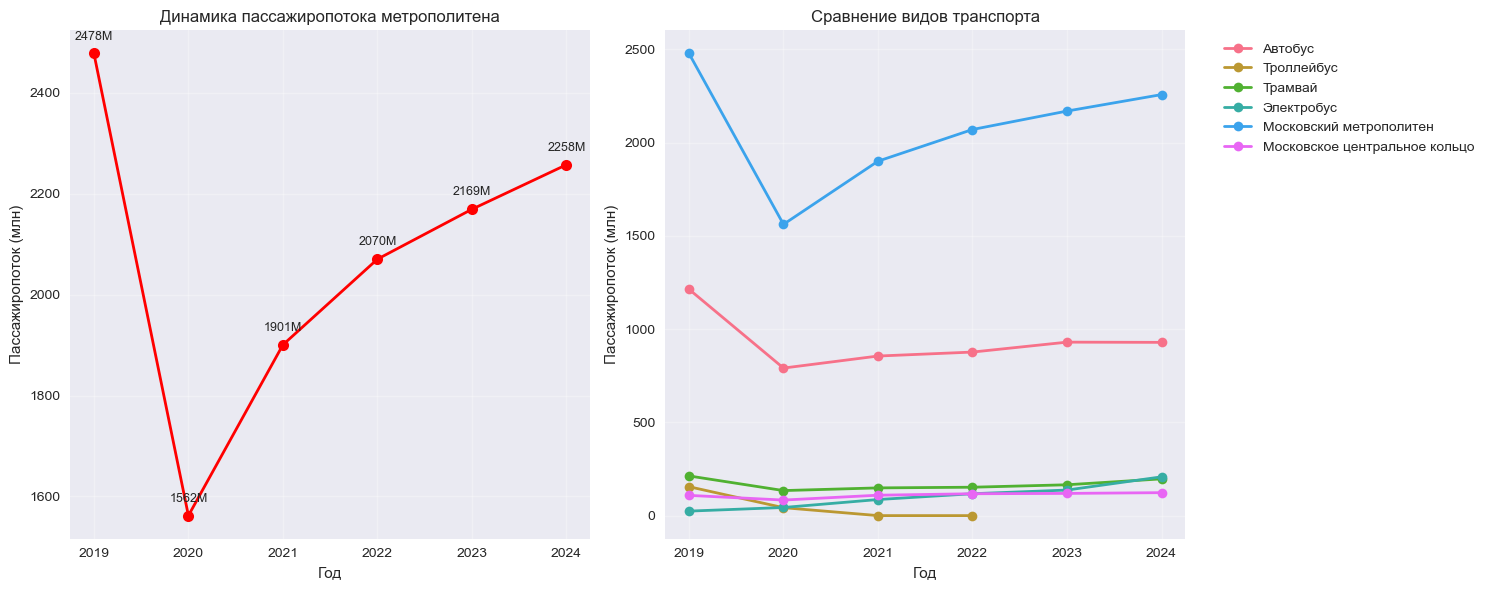

In [49]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Метрополитен
ax1.plot(metro_traffic['Год'], metro_traffic['Пассажирский поток (млн)'], 
         marker='o', linewidth=2, markersize=8, color='red')
ax1.set_title('Динамика пассажиропотока метрополитена')
ax1.set_xlabel('Год')
ax1.set_ylabel('Пассажиропоток (млн)')
ax1.grid(True, alpha=0.3)
for _, row in metro_traffic.iterrows():
    ax1.annotate(f"{row['Пассажирский поток (млн)']:.0f}M", 
                 (row['Год'], row['Пассажирский поток (млн)']),
                 textcoords="offset points", xytext=(0,10), ha='center', fontsize=9)

# Все виды транспорта
for transport in yearly_clean['Вид общественного транспорта'].unique():
    data = yearly_clean[yearly_clean['Вид общественного транспорта'] == transport].sort_values('Год')
    ax2.plot(data['Год'], data['Пассажирский поток'] / 1e6, 
             marker='o', label=transport, linewidth=2)

ax2.set_title('Сравнение видов транспорта')
ax2.set_xlabel('Год')
ax2.set_ylabel('Пассажиропоток (млн)')
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [50]:
# Определяем данные за последний год
latest_year = 2024
latest_data = yearly_clean[yearly_clean['Год'] == latest_year]

# Пассажиропоток по годам
passenger_2019 = yearly_summary[yearly_summary['Год'] == 2019]['Пассажирский поток (млрд)'].values[0]
passenger_2020 = yearly_summary[yearly_summary['Год'] == 2020]['Пассажирский поток (млрд)'].values[0]
decline_percent = ((passenger_2019 - passenger_2020) / passenger_2019) * 100

recovery_2024 = ((yearly_summary[yearly_summary['Год'] == 2024]['Пассажирский поток (млрд)'].values[0] - passenger_2020) / passenger_2020) * 100
gap_to_2019 = ((passenger_2019 - yearly_summary[yearly_summary['Год'] == 2024]['Пассажирский поток (млрд)'].values[0]) / passenger_2019) * 100


print(f"\nСтруктура пассажиропотока по видам транспорта в {latest_year} году:")
for transport in ['Московский метрополитен', 'Автобус', 'Трамвай', 'Троллейбус', 'Электробус']:
    if transport in latest_data['Вид общественного транспорта'].values:
        traffic = latest_data[latest_data['Вид общественного транспорта'] == transport]['Пассажирский поток'].values[0] / 1e9
        share = (latest_data[latest_data['Вид общественного транспорта'] == transport]['Пассажирский поток'].values[0] / latest_data['Пассажирский поток'].sum()) * 100
        print(f"• {transport}: {traffic:.2f} млрд ({share:.1f}%)")

print("\nАнализ динамики пассажиропотока: пик 2019 и спад 2020")
print("Ключевые показатели:")
print(f"• 2019 год: {passenger_2019:.1f} млрд пассажиров (максимум)")
print(f"• 2020 год: {passenger_2020:.1f} млрд пассажиров")
print(f"• Снижение: {decline_percent:.1f}%")

print("\nВероятные причины спада:")
print("• Ограничения передвижения в связи с пандемией COVID-19")
print("• Переход на удалённую работу и обучение")
print("• Карантинные меры и локдауны")
print("• Сокращение деловой активности и туризма")

print("\nДинамика восстановления:")
print("• 2021–2024: постепенное восстановление пассажиропотока")
print("• Полное восстановление до уровня 2019 не достигнуто")
print("• Изменение транспортных привычек населения")

print("\nОценка восстановления:")
print(f"• Рост с 2020 по 2024: +{recovery_2024:.1f}%")
print(f"• До уровня 2019 не хватает: {gap_to_2019:.1f}%")
print("• Рост устойчив, но темпы ниже допандемийных")


Структура пассажиропотока по видам транспорта в 2024 году:
• Московский метрополитен: 2.26 млрд (60.8%)
• Автобус: 0.93 млрд (25.0%)
• Трамвай: 0.20 млрд (5.3%)
• Электробус: 0.21 млрд (5.6%)

Анализ динамики пассажиропотока: пик 2019 и спад 2020
Ключевые показатели:
• 2019 год: 4.2 млрд пассажиров (максимум)
• 2020 год: 2.7 млрд пассажиров
• Снижение: 36.6%

Вероятные причины спада:
• Ограничения передвижения в связи с пандемией COVID-19
• Переход на удалённую работу и обучение
• Карантинные меры и локдауны
• Сокращение деловой активности и туризма

Динамика восстановления:
• 2021–2024: постепенное восстановление пассажиропотока
• Полное восстановление до уровня 2019 не достигнуто
• Изменение транспортных привычек населения

Оценка восстановления:
• Рост с 2020 по 2024: +39.8%
• До уровня 2019 не хватает: 11.4%
• Рост устойчив, но темпы ниже допандемийных


In [51]:
quarter_mapping = {'I квартал': 1, 'II квартал': 2, 'III квартал': 3, 'IV квартал': 4}
passenger_flow = metro_data_clean['passenger_flow'].copy()
passenger_flow['Квартал_число'] = passenger_flow['Квартал'].map(quarter_mapping)

quarterly_stats = passenger_flow.groupby(['Год', 'Квартал_число']).agg({
    'Входы пассажиров': 'sum', 'Выходы пассажиров': 'sum'
}).reset_index()
quarterly_stats['Общий пассажиропоток (млн)'] = (quarterly_stats['Входы пассажиров'] + quarterly_stats['Выходы пассажиров']) / 1e6
quarterly_stats['Общий пассажиропоток (млн)'] = quarterly_stats['Общий пассажиропоток (млн)'].round(1)
quarterly_stats = quarterly_stats.sort_values(['Год', 'Квартал_число']).reset_index(drop=True)

display(quarterly_stats.head(10))

Год  Квартал_число  Входы пассажиров  Выходы пассажиров  \
0  2021              1         452934258          453486462   
1  2021              2         513138155          513385118   
2  2021              3         495109032          495291549   
3  2021              4         549016205          544617362   
4  2022              1         503997473          504303169   
5  2022              2         558097044          558442438   
6  2022              3         543475571          543757171   
7  2022              4         578754407          579120385   
8  2023              1         528437875          528440389   
9  2023              2         577779722          577799126   

   Общий пассажиропоток (млн)  
0                       906.4  
1                      1026.5  
2                       990.4  
3                      1093.6  
4                      1008.3  
5                      1116.5  
6                      1087.2  
7                      1157.9  
8                      1056.9  
9                      1155.6

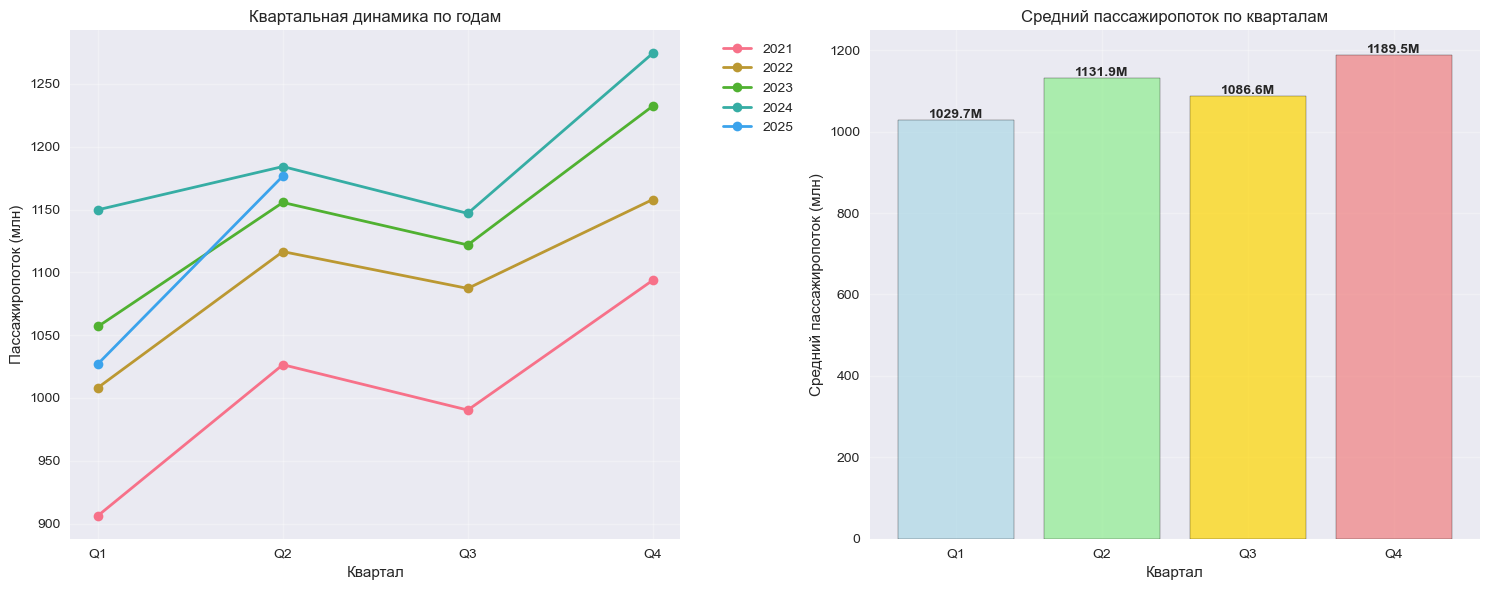

In [52]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# По годам
for year in sorted(quarterly_stats['Год'].unique()):
    data = quarterly_stats[quarterly_stats['Год'] == year]
    ax1.plot(data['Квартал_число'], data['Общий пассажиропоток (млн)'], 
             marker='o', label=year, linewidth=2)

ax1.set_title('Квартальная динамика по годам')
ax1.set_xlabel('Квартал')
ax1.set_ylabel('Пассажиропоток (млн)')
ax1.set_xticks([1, 2, 3, 4])
ax1.set_xticklabels(['Q1', 'Q2', 'Q3', 'Q4'])
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(True, alpha=0.3)

# Среднее по кварталам
quarter_avg = quarterly_stats.groupby('Квартал_число')['Общий пассажиропоток (млн)'].mean()
quarters = ['Q1', 'Q2', 'Q3', 'Q4']
bars = ax2.bar(quarters, quarter_avg.values, 
               color=['lightblue', 'lightgreen', 'gold', 'lightcoral'], 
               alpha=0.7, edgecolor='black')
ax2.set_title('Средний пассажиропоток по кварталам')
ax2.set_xlabel('Квартал')
ax2.set_ylabel('Средний пассажиропоток (млн)')
ax2.grid(True, alpha=0.3)
for bar, value in zip(bars, quarter_avg.values):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
             f'{value:.1f}M', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

In [53]:
q1_avg = quarterly_stats[quarterly_stats['Квартал_число'] == 1]['Общий пассажиропоток (млн)'].mean()
q2_avg = quarterly_stats[quarterly_stats['Квартал_число'] == 2]['Общий пассажиропоток (млн)'].mean()
q3_avg = quarterly_stats[quarterly_stats['Квартал_число'] == 3]['Общий пассажиропоток (млн)'].mean()
q4_avg = quarterly_stats[quarterly_stats['Квартал_число'] == 4]['Общий пассажиропоток (млн)'].mean()

q1_avg = quarterly_stats[quarterly_stats['Квартал_число'] == 1]['Общий пассажиропоток (млн)'].mean()
q2_avg = quarterly_stats[quarterly_stats['Квартал_число'] == 2]['Общий пассажиропоток (млн)'].mean()
q3_avg = quarterly_stats[quarterly_stats['Квартал_число'] == 3]['Общий пассажиропоток (млн)'].mean()
q4_avg = quarterly_stats[quarterly_stats['Квартал_число'] == 4]['Общий пассажиропоток (млн)'].mean()

print("\nСезонные паттерны пассажиропотока:")
print(f"• Q1 (январь–март): {q1_avg:.1f} млн — зимний период")
print(f"• Q2 (апрель–июнь): {q2_avg:.1f} млн — весна и начало лета")
print(f"• Q3 (июль–сентябрь): {q3_avg:.1f} млн — летние отпуска")
print(f"• Q4 (октябрь–декабрь): {q4_avg:.1f} млн — осень и начало зимы")

print("\nКлючевые наблюдения:")
print("• Наблюдается ежегодный рост — восстановление после пандемии")
print("• Максимальная нагрузка в Q4 — возврат с отпусков, начало учебного года")
print("• Минимальная нагрузка в Q3 — летние каникулы и отпуска")
print("• Q2 и Q4 — периоды наибольшей активности")

print("\nФакторы влияния:")
print("• Летние каникулы и отпуска (Q3)")
print("• Начало учебного года (Q4)")
print("• Зимние праздники и короткий световой день (Q1)")
print("• Весеннее оживление активности (Q2)")

print("\nВыводы:")
print(f"• Пик: 2019 ({passenger_2019:.1f} млрд), спад 2020: -{decline_percent:.1f}%")
print(f"• Восстановление 2020→2024: +{recovery_2024:.1f}%, до 2019: -{gap_to_2019:.1f}%")
print(f"• Сезонность: Q3 — спад ({q3_avg:.1f} млн), Q4 — пик ({q4_avg:.1f} млн)")
print("• Метрополитен — основа транспортной системы")
print("• Электробусы - новая, но пока небольшая часть системы")


Сезонные паттерны пассажиропотока:
• Q1 (январь–март): 1029.7 млн — зимний период
• Q2 (апрель–июнь): 1131.9 млн — весна и начало лета
• Q3 (июль–сентябрь): 1086.6 млн — летние отпуска
• Q4 (октябрь–декабрь): 1189.5 млн — осень и начало зимы

Ключевые наблюдения:
• Наблюдается ежегодный рост — восстановление после пандемии
• Максимальная нагрузка в Q4 — возврат с отпусков, начало учебного года
• Минимальная нагрузка в Q3 — летние каникулы и отпуска
• Q2 и Q4 — периоды наибольшей активности

Факторы влияния:
• Летние каникулы и отпуска (Q3)
• Начало учебного года (Q4)
• Зимние праздники и короткий световой день (Q1)
• Весеннее оживление активности (Q2)

Выводы:
• Пик: 2019 (4.2 млрд), спад 2020: -36.6%
• Восстановление 2020→2024: +39.8%, до 2019: -11.4%
• Сезонность: Q3 — спад (1086.6 млн), Q4 — пик (1189.5 млн)
• Метрополитен — основа транспортной системы
• Электробусы - новая, но пока небольшая часть системы


## Вкладка 5: Эффективность линий метрополитена

Анализ загрузки и эффективности линий:
- Пассажиропоток по линиям
- Пассажиры на км и на станцию
- Визуализация: горизонтальные барчарты

In [54]:
# Загрузка и очистка данных
line_chars = metro_data_clean['line_characteristics'].copy()
line_chars = line_chars.drop('Unnamed: 5', axis=1, errors='ignore')

line_passengers = metro_data_clean['passenger_flow'].groupby('Линия').agg({
    'Входы пассажиров': 'sum',
    'Выходы пассажиров': 'sum'
}).reset_index()
line_passengers['Общий пассажиропоток (млн)'] = (line_passengers['Входы пассажиров'] + line_passengers['Выходы пассажиров']) / 1e6

top_lines = line_passengers.nlargest(5, 'Общий пассажиропоток (млн)')
print("Топ-5 линий по пассажиропотоку:")
for _, row in top_lines.iterrows():
    print(f"• {row['Линия']}: {row['Общий пассажиропоток (млн)']:.1f} млн")

Топ-5 линий по пассажиропотоку:
• Таганско-Краснопресненская линия: 2391.9 млн
• Калужско-Рижская линия: 2246.6 млн
• Замоскворецкая линия: 2123.6 млн
• Серпуховско-Тимирязевская линия: 2064.3 млн
• Арбатско-Покровская линия: 2017.9 млн


In [55]:
lines_analysis = pd.merge(line_chars, line_passengers[['Линия', 'Общий пассажиропоток (млн)']], on='Линия', how='left')
lines_analysis['Пассажиров на км (млн)'] = lines_analysis['Общий пассажиропоток (млн)'] / lines_analysis['Эксплуатационная длина (км)']
lines_analysis['Пассажиров на станцию (млн)'] = lines_analysis['Общий пассажиропоток (млн)'] / lines_analysis['Количество станций']

top_efficient = lines_analysis.nlargest(5, 'Пассажиров на км (млн)')
print("Самые эффективные линии (пассажиров на км):")
for _, row in top_efficient.iterrows():
    print(f"• {row['Линия']}: {row['Пассажиров на км (млн)']:.2f} млн/км")

top_station_load = lines_analysis.nlargest(5, 'Пассажиров на станцию (млн)')
print("\nСамые загруженные линии (пассажиров на станцию):")
for _, row in top_station_load.iterrows():
    print(f"• {row['Линия']}: {row['Пассажиров на станцию (млн)']:.1f} млн/станцию")

Самые эффективные линии (пассажиров на км):
• Кольцевая линия: 68.56 млн/км
• Калужско-Рижская линия: 59.39 млн/км
• Таганско-Краснопресненская линия: 56.90 млн/км
• Калининская линия: 54.57 млн/км
• Серпуховско-Тимирязевская линия: 49.97 млн/км

Самые загруженные линии (пассажиров на станцию):
• Калининская линия: 110.6 млн/станцию
• Кольцевая линия: 109.5 млн/станцию
• Таганско-Краснопресненская линия: 104.0 млн/станцию
• Калужско-Рижская линия: 93.6 млн/станцию
• Арбатско-Покровская линия: 91.7 млн/станцию


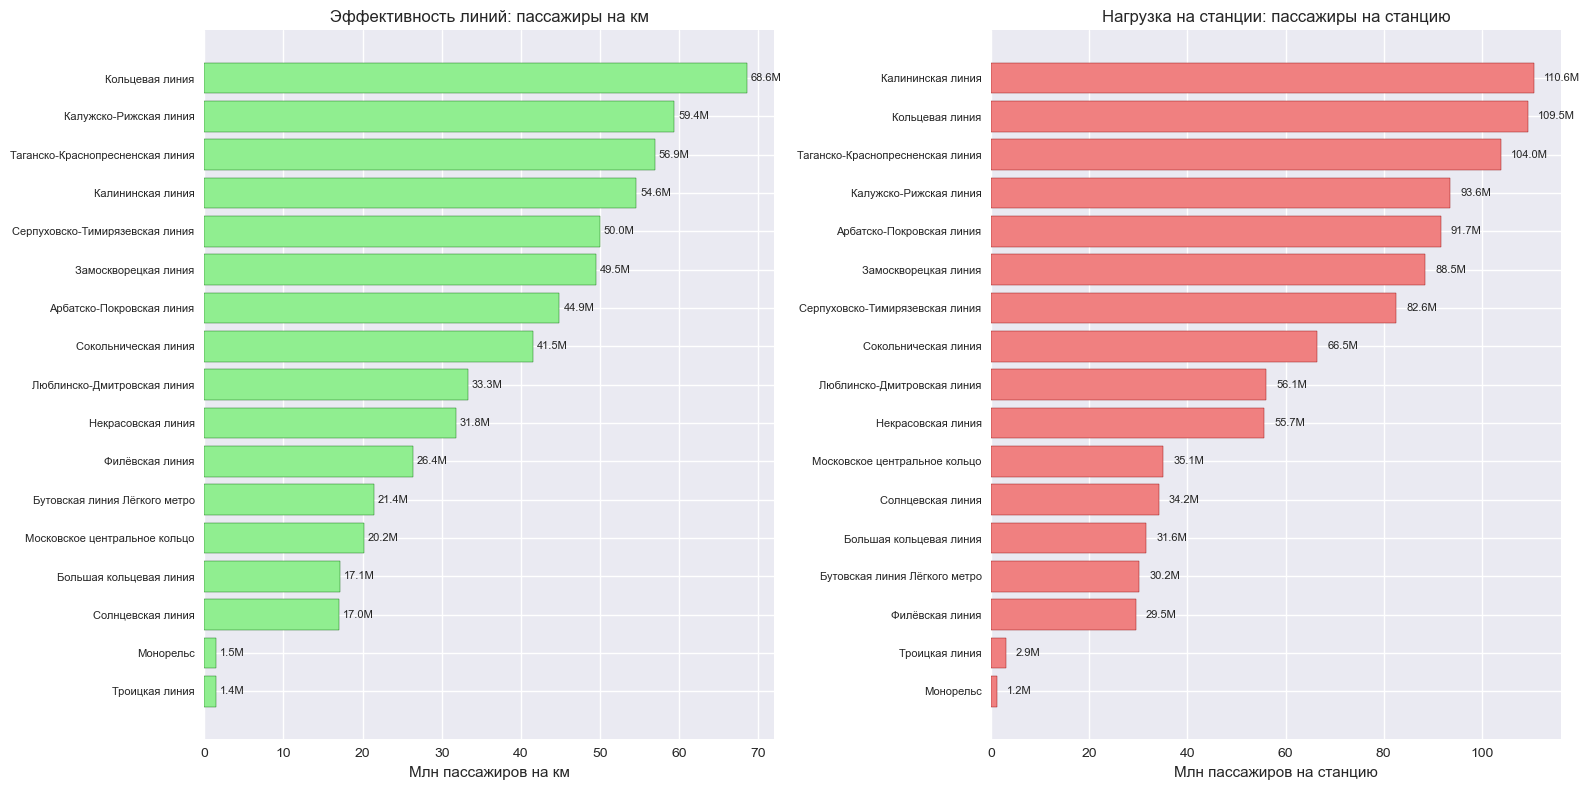

In [56]:
lines_analysis_short = lines_analysis.copy()
lines_analysis_short['Линия'] = lines_analysis_short['Линия'].replace(
    'Московская монорельсовая транспортная система', 'Монорельс'
)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Пассажиры на км
eff = lines_analysis_short.sort_values('Пассажиров на км (млн)')
ax1.barh(eff['Линия'], eff['Пассажиров на км (млн)'], color='lightgreen', edgecolor='darkgreen')
ax1.set_title('Эффективность линий: пассажиры на км')
ax1.set_xlabel('Млн пассажиров на км')
ax1.tick_params(axis='y', labelsize=8)
for bar in ax1.patches:
    ax1.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2,
             f'{bar.get_width():.1f}M', va='center', fontsize=8)

# Пассажиры на станцию
load = lines_analysis_short.sort_values('Пассажиров на станцию (млн)')
ax2.barh(load['Линия'], load['Пассажиров на станцию (млн)'], color='lightcoral', edgecolor='darkred')
ax2.set_title('Нагрузка на станции: пассажиры на станцию')
ax2.set_xlabel('Млн пассажиров на станцию')
ax2.tick_params(axis='y', labelsize=8)
for bar in ax2.patches:
    ax2.text(bar.get_width() + 2, bar.get_y() + bar.get_height()/2,
             f'{bar.get_width():.1f}M', va='center', fontsize=8)

plt.tight_layout()
plt.show()

In [57]:
print("\nВыводы:")
print("• Центральные линии — лидеры по пассажиропотоку и эффективности")
print("• Кольцевые и радиальные линии имеют высокую нагрузку на станцию")
print("• Монорельс — наименее эффективен по пассажирам на км")
print("• Эффективность зависит от плотности застройки и пересадочных узлов")


Выводы:
• Центральные линии — лидеры по пассажиропотоку и эффективности
• Кольцевые и радиальные линии имеют высокую нагрузку на станцию
• Монорельс — наименее эффективен по пассажирам на км
• Эффективность зависит от плотности застройки и пересадочных узлов


## Вкладка 6: Операционная эффективность

Анализ точности соблюдения расписания:
- Средняя, минимальная и максимальная точность
- Динамика по годам
- Связь с пассажиропотоком
- Визуализация: точечная диаграмма

In [58]:
# Загрузка и подготовка данных
schedule_data = metro_data_clean['schedule_precision'].copy()
schedule_data['Квартал_число'] = schedule_data['Квартал'].map({
    'I квартал': 1, 'II квартал': 2, 'III квартал': 3, 'IV квартал': 4
})
schedule_data['Линия'] = schedule_data['Линия'].replace(
    'Московская монорельсовая транспортная система', 'Монорельс'
)

# Базовая статистика
print(f"Годы в данных: {sorted(schedule_data['Год'].unique())}")
print(f"Средняя точность: {schedule_data['Процент выполнения расписания (%)'].mean():.2f}%")
print(f"Минимальная: {schedule_data['Процент выполнения расписания (%)'].min():.2f}%")
print(f"Максимальная: {schedule_data['Процент выполнения расписания (%)'].max():.2f}%")

# Топ-5 самых точных линий (среднее)
line_accuracy = schedule_data.groupby('Линия')['Процент выполнения расписания (%)'].mean()
top_accurate = line_accuracy.nlargest(5)
print("\nТоп-5 линий по средней точности:")
for line, acc in top_accurate.items():
    print(f"• {line}: {acc:.3f}%")

Годы в данных: [np.int64(2021), np.int64(2022), np.int64(2023), np.int64(2024), np.int64(2025)]
Средняя точность: 99.97%
Минимальная: 99.00%
Максимальная: 100.00%

Топ-5 линий по средней точности:
• Монорельс: 100.000%
• Филёвская линия: 99.993%
• Солнцевская линия: 99.993%
• Арбатско-Покровская линия: 99.992%
• Сокольническая линия: 99.990%


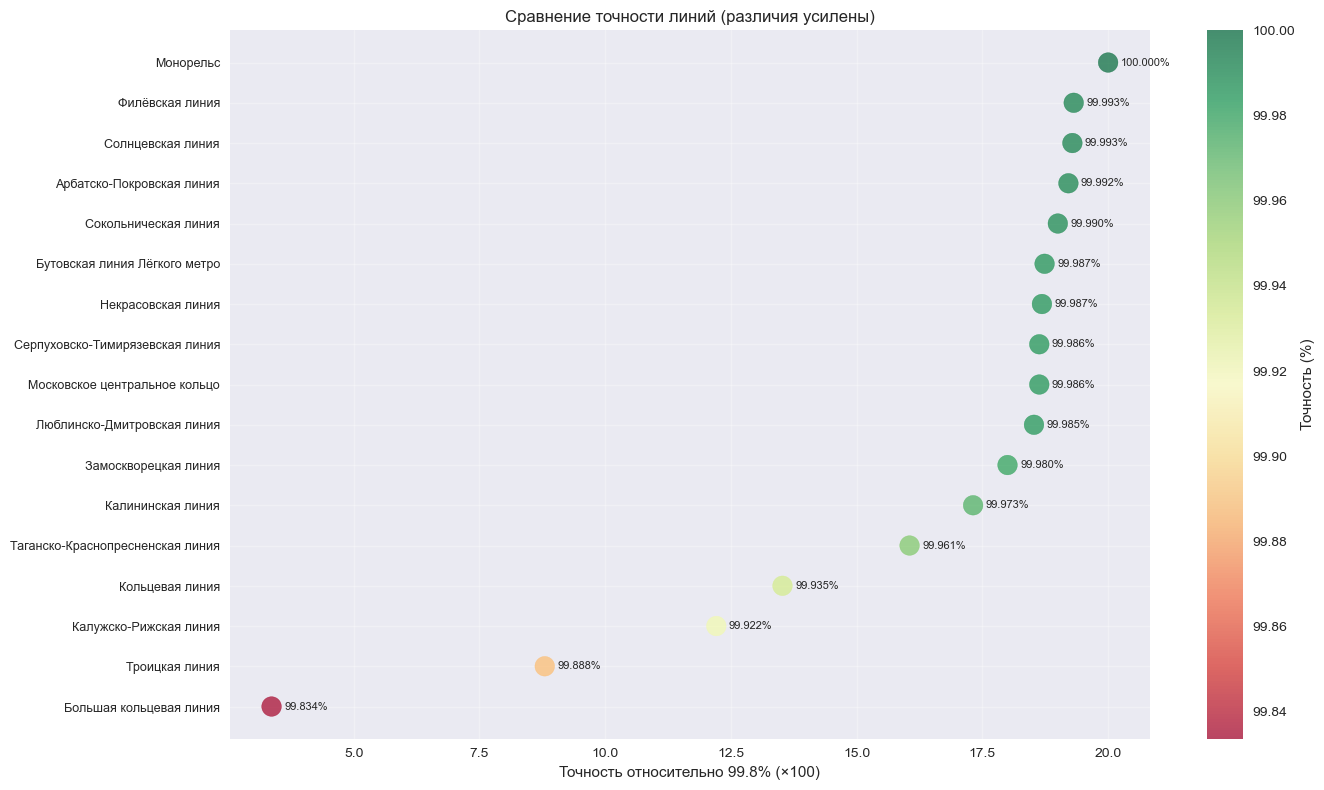

In [59]:
fig, ax = plt.subplots(figsize=(14, 8))

# Усиливаем различия для визуализации
accuracy_sorted = line_accuracy.sort_values()
emphasized = (accuracy_sorted - 99.8) * 100

scatter = ax.scatter(emphasized, range(len(accuracy_sorted)),
                    s=200, c=accuracy_sorted, cmap='RdYlGn', alpha=0.7)

ax.set_yticks(range(len(accuracy_sorted)))
ax.set_yticklabels(accuracy_sorted.index, fontsize=9)
ax.set_xlabel('Точность относительно 99.8% (×100)')
ax.set_title('Сравнение точности линий (различия усилены)')
ax.grid(True, alpha=0.3)

# Подписи с реальными значениями
for i, (line, acc) in enumerate(accuracy_sorted.items()):
    ax.text(emphasized.iloc[i] + 0.25, i, f'{acc:.3f}%', va='center', fontsize=8)

cbar = plt.colorbar(scatter)
cbar.set_label('Точность (%)')

plt.tight_layout()
plt.show()

In [60]:
bkl_data = schedule_data[schedule_data['Линия'] == 'Большая кольцевая линия']
if not bkl_data.empty:
    print("Динамика точности БКЛ:")
    bkl_yearly = bkl_data.groupby('Год')['Процент выполнения расписания (%)'].mean()
    for year, acc in bkl_yearly.items():
        print(f"• {year}: {acc:.3f}%")
else:
    print("БКЛ отсутствует в данных")

print("\nДинамика точности по годам (все линии):")
yearly_accuracy = schedule_data.groupby(['Линия', 'Год'])['Процент выполнения расписания (%)'].mean().round(3)
display(yearly_accuracy.unstack())

Динамика точности БКЛ:
• 2021: 99.985%
• 2022: 99.992%
• 2023: 99.983%
• 2024: 99.847%
• 2025: 99.203%

Динамика точности по годам (все линии):


Год                                  2021     2022     2023     2024     2025
Линия                                                                        
Арбатско-Покровская линия          99.990   99.998   99.992   99.992   99.987
Большая кольцевая линия            99.985   99.992   99.982   99.848   99.203
Бутовская линия Лёгкого метро      99.975   99.990   99.990   99.992   99.990
Замоскворецкая линия               99.990   99.990   99.992   99.977   99.940
Калининская линия                  99.975   99.988   99.972   99.960   99.970
Калужско-Рижская линия             99.985   99.990   99.988   99.898   99.693
Кольцевая линия                    99.938   99.977   99.975   99.878   99.900
Люблинско-Дмитровская линия        99.990   99.992   99.990   99.982   99.967
Монорельс                         100.000  100.000  100.000  100.000  100.000
Московское центральное кольцо      99.982   99.982   99.988   99.992   99.987
Некрасовская линия                 99.998   99.995   99.995   99.990   99.947
Серпуховско-Тимирязевская линия    99.988   99.990   99.992   99.985   99.973
Сокольническая линия               99.990   99.990   99.992   99.990   99.987
Солнцевская линия                  99.990   99.994   99.992   99.992   99.997
Таганско-Краснопресненская линия   99.988   99.982   99.988   99.932   99.897
Троицкая линия                        NaN      NaN      NaN   99.935   99.857
Филёвская линия                    99.990   99.992   99.998   99.995   99.990

In [61]:
# Объединение с пассажиропотоком из Вкладки 5
accuracy_vs_traffic = pd.merge(
    line_accuracy.reset_index(),
    lines_analysis[['Линия', 'Общий пассажиропоток (млн)']],
    on='Линия',
    how='left'
).rename(columns={
    'Процент выполнения расписания (%)': 'Точность_%',
    'Общий пассажиропоток (млн)': 'Пассажиропоток_млн'
})

print("Связь точности и пассажиропотока:")
display(accuracy_vs_traffic.round(3))

Связь точности и пассажиропотока:


Линия  Точность_%  Пассажиропоток_млн
0          Арбатско-Покровская линия      99.992            2017.931
1            Большая кольцевая линия      99.834             980.712
2      Бутовская линия Лёгкого метро      99.987             211.424
3               Замоскворецкая линия      99.980            2123.639
4                  Калининская линия      99.973             885.051
5             Калужско-Рижская линия      99.922            2246.641
6                    Кольцевая линия      99.935            1314.205
7        Люблинско-Дмитровская линия      99.985            1457.907
8                          Монорельс     100.000                 NaN
9      Московское центральное кольцо      99.986            1088.103
10                Некрасовская линия      99.987             445.535
11   Серпуховско-Тимирязевская линия      99.986            2064.298
12              Сокольническая линия      99.990            1795.669
13                 Солнцевская линия      99.993             478.374
14  Таганско-Краснопресненская линия      99.961            2391.887
15                    Троицкая линия      99.888              20.543
16                   Филёвская линия      99.993             383.336

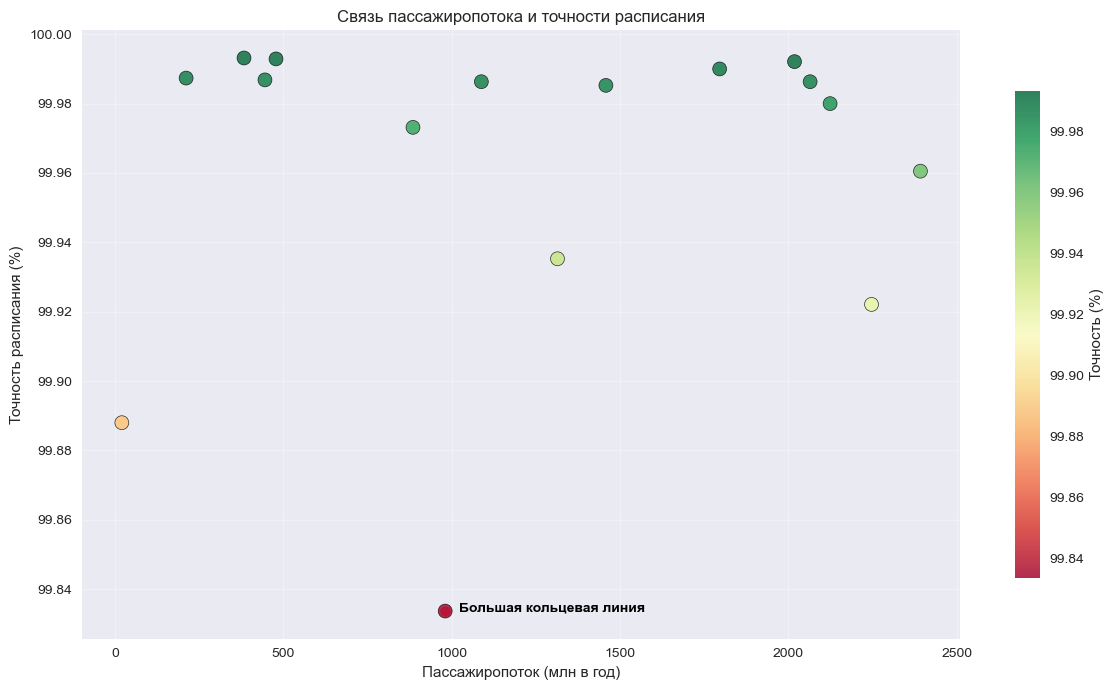

In [62]:
# Фильтрация
valid_data = accuracy_vs_traffic[accuracy_vs_traffic['Пассажиропоток_млн'].notna()].copy()

if not valid_data.empty:
    fig, ax = plt.subplots(figsize=(12, 7))

    # Все линии — обычные точки
    scatter = ax.scatter(
        valid_data['Пассажиропоток_млн'], valid_data['Точность_%'],
        s=100, c=valid_data['Точность_%'], cmap='RdYlGn',
        alpha=0.8, edgecolors='black', linewidth=0.5, zorder=5
    )

    # ВЫДЕЛЯЕМ ТОЛЬКО БКЛ
    bkl = valid_data[valid_data['Линия'] == 'Большая кольцевая линия']
    if not bkl.empty:
        ax.scatter(
            bkl['Пассажиропоток_млн'], bkl['Точность_%'],
            label='Большая кольцевая линия'
        )
        ax.annotate(
            'Большая кольцевая линия',
            xy=(bkl['Пассажиропоток_млн'].iloc[0], bkl['Точность_%'].iloc[0]),
            xytext=(10, 0), textcoords='offset points',
            fontsize=10, fontweight='bold', color='black',
        )

    ax.set_xlabel('Пассажиропоток (млн в год)')
    ax.set_ylabel('Точность расписания (%)')
    ax.set_title('Связь пассажиропотока и точности расписания')
    ax.grid(True, alpha=0.3, zorder=0)

    # Цветовая шкала
    cbar = plt.colorbar(scatter, shrink=0.8)
    cbar.set_label('Точность (%)')

    plt.tight_layout()
    plt.show()
else:
    print("Нет данных для графика")

In [63]:
print("\nВыводы:")
print("• Средняя точность по сети — выше 99.8%")
print("• Новые линии (особенно БКЛ) демонстрируют снижение точности со временем")
print("• Стабильные линии (Некрасовская, Солнцевская) — выше 99.9%")
print("• Корреляция между пассажиропотоком и точностью не выявлена")
print("• Операционная эффективность высока, но требует мониторинга на новых участках")


Выводы:
• Средняя точность по сети — выше 99.8%
• Новые линии (особенно БКЛ) демонстрируют снижение точности со временем
• Стабильные линии (Некрасовская, Солнцевская) — выше 99.9%
• Корреляция между пассажиропотоком и точностью не выявлена
• Операционная эффективность высока, но требует мониторинга на новых участках


## Вкладка 7: Анализ тарифов и выручки

Анализ:
- Основные тарифы (без льгот)
- Суточная стоимость
- Сценарии использования
- Оценка выручки метрополитена

In [64]:
# Загрузка и фильтрация
metro_tariffs = metro_data_clean['tariffs'].copy()

# Только метро
metro_tariffs = metro_tariffs[
    metro_tariffs['Вид транспорта'].str.contains('Метрополитен', na=False)
].copy()

# Исключаем льготные и лишнее
metro_tariffs = metro_tariffs[
    ~metro_tariffs['Наименование тарифа'].str.contains(
        'льгот|обучающихся|багаж', 
        na=False, case=False
    )
].copy()

price_col = 'Стоимость проездного документа (рублей)'
metro_tariffs[price_col] = pd.to_numeric(metro_tariffs[price_col], errors='coerce')
metro_tariffs = metro_tariffs.dropna(subset=[price_col])

# Переименование тарифов
rename_map = {
    "Проездной билет на 1 поездку, дающий право проезда при аутоинтефикации на основании изображения пассажира": "Оплата улыбкой",
    "«Кошелек» метро/монорельс/МЦК/МЦД": "«Кошелек»",
    "Банковская карта с технологией бесконтактной оплаты": "Оплата картой"
}
metro_tariffs['Наименование тарифа'] = metro_tariffs['Наименование тарифа'].replace(rename_map)

# Сортировка для Москвы
main_tariffs = metro_tariffs[metro_tariffs['Наименование тарифа'].str.contains('Единый')].sort_values(price_col)
wallet_tariffs = metro_tariffs[metro_tariffs['Наименование тарифа'].str.contains('Кошел')].sort_values(price_col, ascending=False)
other_tariffs = metro_tariffs[~metro_tariffs['Наименование тарифа'].str.contains('Единый|Кошел')].sort_values(price_col, ascending=False)

final_tariffs = pd.concat([main_tariffs, wallet_tariffs, other_tariffs]).reset_index(drop=True)

# Разделение: Москва и Пригород
final_tariffs_moscow = final_tariffs[
    final_tariffs['Вид транспорта'].str.contains('Центральная', na=False)
].copy()

final_tariffs_suburb = final_tariffs[
    final_tariffs['Вид транспорта'].str.contains('Пригород', na=False)
].copy()

# Вывод
columns_to_show = ['Наименование тарифа', price_col, 'Срок действия проездного документа']

styled_table(
    final_tariffs_moscow[columns_to_show], 
    title="ТАРИФЫ МОСКВА (Зона Центральная)",
    wrap_columns=['Наименование тарифа', 'Срок действия проездного документа']
)

styled_table(
    final_tariffs_suburb[columns_to_show],
    title="ТАРИФЫ ПРИГОРОД (Зона Пригород)", 
    wrap_columns=['Наименование тарифа', 'Срок действия проездного документа']
)


ТАРИФЫ МОСКВА (Зона Центральная)



ТАРИФЫ ПРИГОРОД (Зона Пригород)



Визуализация суточной стоимости тарифов:


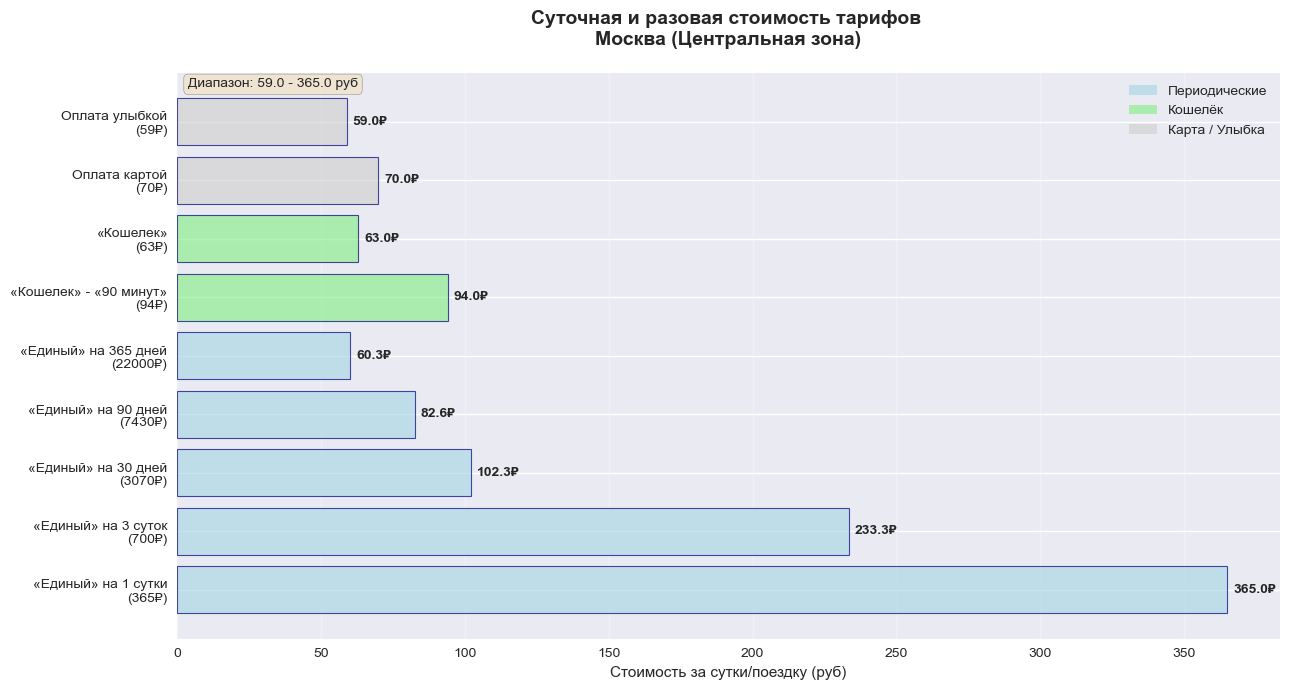


Статистика тарифов:
• Всего тарифов (не включая льготных): 9
• Самый дешёвый: 59.0 руб - Оплата улыбкой
• Самый дорогой: 365.0 руб - «Единый» на 1 сутки


In [65]:
print("\nВизуализация суточной стоимости тарифов:")

# Подготовка данных
onetime_costs = []
display_names = []
colors = []

for _, row in final_tariffs_moscow.iterrows():
    name = row['Наименование тарифа']
    cost = row['Стоимость проездного документа (рублей)']
    
    # Определяем суточную стоимость и цвет
    if '1 сутки' in name:
        onetime_cost = cost
        color = 'lightblue'
    elif '3 суток' in name:
        onetime_cost = cost / 3
        color = 'lightblue'
    elif '30 дней' in name:
        onetime_cost = cost / 30
        color = 'lightblue'
    elif '90 дней' in name:
        onetime_cost = cost / 90
        color = 'lightblue'
    elif '365 дней' in name:
        onetime_cost = cost / 365
        color = 'lightblue'
    elif 'Кошелек' in name:
        onetime_cost = cost
        color = 'lightgreen'
    else:
        # Все остальные тарифы (картой, улыбкой)
        onetime_cost = cost
        color = 'lightgray'
    
    display_name = f"{name}\n({cost}₽)"
    
    onetime_costs.append(onetime_cost)
    display_names.append(display_name)
    colors.append(color)


# График
fig, ax = plt.subplots(figsize=(13, 7))

bars = ax.barh(display_names, onetime_costs,
               color=colors, alpha=0.7, edgecolor='navy', linewidth=0.8)

ax.set_title('Суточная и разовая стоимость тарифов \nМосква (Центральная зона)', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Стоимость за сутки/поездку (руб)', fontsize=11)

# Сетка
ax.grid(True, alpha=0.3, axis='x')
ax.set_axisbelow(True)

# Подписи на столбцах
for bar, onetime_cost in zip(bars, onetime_costs):
    ax.text(bar.get_width() + 2, bar.get_y() + bar.get_height()/2,
            f'{onetime_cost:.1f}₽', ha='left', va='center', fontweight='bold')

# Дополнительная информация по тарифам Единый
min_cost = min(onetime_costs)
max_cost = max(onetime_costs)
ax.text(0.01, 0.99, f'Диапазон: {min_cost:.1f} - {max_cost:.1f} руб', 
        transform=ax.transAxes, fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Легенда 
legend_elements = [
    plt.Rectangle((0,0), 1, 1, fc='lightblue', alpha=0.7, label='Периодические'),
    plt.Rectangle((0,0), 1, 1, fc='lightgreen', alpha=0.7, label='Кошелёк'),
    plt.Rectangle((0,0), 1, 1, fc='lightgray', alpha=0.7, label='Карта / Улыбка')
]
ax.legend(handles=legend_elements, loc='upper right', framealpha=0.9)

plt.tight_layout()
plt.show()

# Находим индексы
min_idx = onetime_costs.index(min(onetime_costs))
max_idx = onetime_costs.index(max(onetime_costs))

# Получаем названия без цены в скобках
min_name = display_names[min_idx].split('\n')[0]  # Берем только первую строку до \n
max_name = display_names[max_idx].split('\n')[0]

print(f"\nСтатистика тарифов:")
print(f"• Всего тарифов (не включая льготных): {len(onetime_costs)}")
print(f"• Самый дешёвый: {onetime_costs[min_idx]:.1f} руб - {min_name}")
print(f"• Самый дорогой: {onetime_costs[max_idx]:.1f} руб - {max_name}")

In [66]:
# Находим суточную стоимость 30-дневного тарифа
daily_cost_30days = None
price_single = None

for cost, name in zip(onetime_costs, final_tariffs_moscow['Наименование тарифа']):
    if '30 дней' in name:
        daily_cost_30days = cost
    elif 'Кошелек' in name and '90 минут' not in name:
        price_single = cost

print("\nСценарий 'Только работа' (40 поездок/месяц):")
work_only_30days = daily_cost_30days * 30  # Суточная × 30 дней
work_only_single = 40 * price_single
print(f"• 30-дневный тариф: {work_only_30days:.0f}₽")
print(f"• Разовые поездки: {work_only_single:.0f}₽")
print(f"• Переплата при тарифе: {work_only_30days - work_only_single:.0f}₽ в месяц")

print(f"\nСценарий 'Каждый день' (60 поездок/месяц):")
daily_30days = daily_cost_30days * 30
daily_single = 60 * price_single
print(f"• 30-дневный тариф: {daily_30days:.0f}₽")
print(f"• Разовые поездки: {daily_single:.0f}₽")
print(f"• Экономия: {daily_single - daily_30days:.0f}₽ в месяц")

# Порог окупаемости = полная стоимость тарифа / цена поездки
break_even = (daily_cost_30days * 30) / price_single
print(f"\nПорог окупаемости 30-дневного тарифа:~ {break_even:.0f} поездок/месяц")

latest_passengers = yearly_summary[yearly_summary['Год'] == latest_year]['Пассажирский поток'].values[0]

avg_ticket_price = (63 + 102.3) / 2
estimated_revenue = latest_passengers * avg_ticket_price

print(f"\nАнализ выручки Метро:")
print(f"• Пассажиропоток {latest_year}: {latest_passengers/1e9:.1f} млрд")
print(f"• Средняя стоимость поездки: {avg_ticket_price:.1f}₽")
print(f"• Оценочная выручка: {estimated_revenue/1e9:.1f} млрд рублей")

print("\nВыводы:")
print(f"• 'Только работа': выгоднее разовые поездки (экономия {work_only_single - work_only_30days:.0f}₽)")
print(f"• 'Каждый день': выгоднее 30-дневный тариф (экономия {daily_single - daily_30days:.0f}₽)")
print(f"• 30-дневный тариф выгоден при ≥ {break_even:.0f} поездок/месяц")
print(f"• При редких поездках — выгоднее {min_name} ({onetime_costs[min_idx]:.1f}₽)")
print("• Тарифы универсальны: работают в метро + МЦД")
print("• Тарифная политика сбалансирована по сценариям")



Сценарий 'Только работа' (40 поездок/месяц):
• 30-дневный тариф: 3070₽
• Разовые поездки: 2520₽
• Переплата при тарифе: 550₽ в месяц

Сценарий 'Каждый день' (60 поездок/месяц):
• 30-дневный тариф: 3070₽
• Разовые поездки: 3780₽
• Экономия: 710₽ в месяц

Порог окупаемости 30-дневного тарифа:~ 49 поездок/месяц

Анализ выручки Метро:
• Пассажиропоток 2024: 3.7 млрд
• Средняя стоимость поездки: 82.7₽
• Оценочная выручка: 307.0 млрд рублей

Выводы:
• 'Только работа': выгоднее разовые поездки (экономия -550₽)
• 'Каждый день': выгоднее 30-дневный тариф (экономия 710₽)
• 30-дневный тариф выгоден при ≥ 49 поездок/месяц
• При редких поездках — выгоднее Оплата улыбкой (59.0₽)
• Тарифы универсальны: работают в метро + МЦД
• Тарифная политика сбалансирована по сценариям


## Вкладка 8: Детализация МЦД

Анализ инфраструктуры МЦД:
- Распределение по территории и округам
- Парсинг станций (диаметр, маршрут)
- Карта станций
- Сравнение с метрополитеном

In [67]:
# Загрузка данных
mcd_entrances = metro_data_clean['mcd_entrances'].copy()
mcd_stations = metro_data_clean['mcd_stations'].copy()

# Парсинг станции МЦД
def parse_mcd_station(text):
    if pd.isna(text):
        return None, None, None
    station = diameter = route = None
    for line in str(text).split('\n'):
        if 'StationName:' in line:
            station = line.split('StationName:')[1].strip()
        elif 'DiameterName:' in line:
            diameter = line.split('DiameterName:')[1].strip()
        elif 'RouteName:' in line:
            route = line.split('RouteName:')[1].strip()
    return station, diameter, route

mcd_entrances[['Станция', 'Диаметр', 'Маршрут']] = mcd_entrances['Станция МЦД'].apply(
    lambda x: pd.Series(parse_mcd_station(x))
)

moscow_mcd = mcd_entrances[mcd_entrances['На территории Москвы'] == 'да'].copy()

# Преобразуем Series в DataFrame и сбрасываем индекс для красивого отображения
value_counts_df = mcd_entrances['На территории Москвы'].value_counts().reset_index()
value_counts_df.columns = ['На территории Москвы', 'Количество']

print("\nРаспределение по территории Москвы:")
display(value_counts_df.style.hide(axis="index"))

print("\nАдминистративные округа (Москва):")
display(moscow_mcd['Административный округ'].value_counts().head(10).to_frame('Количество входов'))

print(f"\nСтатистика:")
print(f"• Всего входов/выходов: {len(mcd_entrances)}")
print(f"• В Москве: {len(moscow_mcd)} ({len(moscow_mcd)/len(mcd_entrances)*100:.1f}%)")
print(f"• За пределами Москвы: {len(mcd_entrances) - len(moscow_mcd)}")


Распределение по территории Москвы:



Административные округа (Москва):


Количество входов
Административный округ                                    
Юго-Восточный административный округ                    45
Северо-Восточный административный округ                 35
Западный административный округ                         34
Северный административный округ                         33
Центральный административный округ                      21
Новомосковский административный округ                   19
Восточный административный округ                        16
Южный административный округ                            15
Северо-Западный административный округ                  11
Зеленоградский административный округ                    9


Статистика:
• Всего входов/выходов: 397
• В Москве: 244 (61.5%)
• За пределами Москвы: 153


In [68]:
diameter_stats = mcd_entrances.groupby('Диаметр').agg({
    'Станция': 'nunique',
    'Наименование прохода станции МЦД': 'count'
}).rename(columns={
    'Станция': 'Уникальные станции',
    'Наименование прохода станции МЦД': 'Входов/выходов'
})

print("Распределение по диаметрам:")
display(diameter_stats)

print(f"\nТоп-10 районов Москвы по входам МЦД:")
display(moscow_mcd['Район'].value_counts().head(10).to_frame('Количество входов'))

print(f"\nГеографический охват:")
print(f"• Уникальных станций МЦД: {mcd_entrances['Станция'].nunique()}")
print(f"• Среднее входов на станцию: {len(mcd_entrances) / mcd_entrances['Станция'].nunique():.1f}")

Распределение по диаметрам:


Уникальные станции  Входов/выходов
Диаметр                                    
МЦД-1                    25              87
МЦД-2                    35             108
МЦД-3                    39             129
МЦД-4                    36              73


Топ-10 районов Москвы по входам МЦД:


Количество входов
Район                                 
район Внуково                       14
Нижегородский район                 13
Можайский район                     10
район Печатники                      9
район Отрадное                       8
Бутырский район                      7
район Солнцево                       7
Тимирязевский район                  7
район Царицыно                       7
район Лианозово                      7


Географический охват:
• Уникальных станций МЦД: 132
• Среднее входов на станцию: 3.0


In [69]:
moscow_center = [55.7558, 37.6173]
mcd_map = folium.Map(
    location=moscow_center,
    zoom_start=10,
    tiles='OpenStreetMap',
    attr='',
    scrollWheelZoom='center'
)

# Убираем подпись Leaflet
mcd_map.get_root().html.add_child(folium.Element("""
<style>
    .leaflet-control-attribution { display: none !important; }
</style>
"""))

mcd_colors = {
    'МЦД-1': 'blue',
    'МЦД-2': 'red', 
    'МЦД-3': 'green',
    'МЦД-4': 'purple'
}

for _, row in mcd_stations.iterrows():
    coords = extract_coords(row['geoData'])
    if coords:
        popup = f"""
        <b>{row['Наименование станции МЦД']}</b><br>
        Диаметр: {row['Наименование МЦД']}<br>
        Район: {row['Район']}<br>
        Населённый пункт: {row['Населенный пункт']}
        """
        color = mcd_colors.get(row['Наименование МЦД'], 'gray')
        
        folium.Marker(
            location=coords,
            popup=folium.Popup(popup, max_width=300),
            tooltip=f"{row['Наименование станции МЦД']} ({row['Наименование МЦД']})",
            icon=folium.Icon(color=color, icon='train', prefix='fa')
        ).add_to(mcd_map)

mcd_map.get_root().width = "1200px"
mcd_map.get_root().height = "700px"
mcd_map

In [70]:
comparison_data = {
    'Показатель': ['Станции', 'Входы/выходы', 'Среднее входов на станцию', 'Охват за пределами Москвы'],
    'МЦД': [
        mcd_entrances['Станция'].nunique(),
        len(mcd_entrances),
        f"~{len(mcd_entrances) / mcd_entrances['Станция'].nunique():.0f}",
        f"{(len(mcd_entrances) - len(moscow_mcd))/len(mcd_entrances)*100:.1f}%"
    ],
    'Метрополитен': [
        metro_data_clean['stations']['Станция метрополитена'].nunique(),
        len(metro_data_clean['stations']),
        f"~{len(metro_data_clean['stations']) / metro_data_clean['stations']['Станция метрополитена'].nunique():.0f}",
        'минимальный'
    ]
}
comparison_df = pd.DataFrame(comparison_data)
display(comparison_df)

print("\nВыводы:")
print(f"• МЦД-3 — лидер ({diameter_stats.loc['МЦД-3', 'Уникальные станции'] if 'МЦД-3' in diameter_stats.index else 0} станций, {diameter_stats.loc['МЦД-3', 'Входов/выходов'] if 'МЦД-3' in diameter_stats.index else 0} входов)")
print(f"• {(len(mcd_entrances) - len(moscow_mcd))/len(mcd_entrances)*100:.1f}% входов — за пределами Москвы")
print(f"• Среднее ~ {len(mcd_entrances) / mcd_entrances['Станция'].nunique():.0f} входа на станцию")
print("• МЦД дополняет метро, расширяя сеть в пригороды")
print("• 89 пересадок — высокая интеграция")

Показатель    МЦД Метрополитен
0                    Станции    132          257
1               Входы/выходы    397         1157
2  Среднее входов на станцию     ~3           ~5
3  Охват за пределами Москвы  38.5%  минимальный


Выводы:
• МЦД-3 — лидер (39 станций, 129 входов)
• 38.5% входов — за пределами Москвы
• Среднее ~ 3 входа на станцию
• МЦД дополняет метро, расширяя сеть в пригороды
• 89 пересадок — высокая интеграция


In [71]:
# HTML только с результатами
!jupyter nbconvert "metro_analysis.ipynb" --to html --no-input --output "../export/report_clean.html"

[NbConvertApp] Converting notebook metro_analysis.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 10 image(s).
[NbConvertApp] Writing 3580368 bytes to ..\export\report_clean.html
